In [211]:
import os
from os.path import isfile, isdir, join
import logging

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily
import itertools

import crime_patterns.utilities as utils

import seaborn
from pysal.viz import splot
from splot.esda import plot_moran

from pysal.explore import esda
from pysal.lib import weights
import libpysal
from libpysal.weights import Queen, Rook, KNN
from numpy.random import seed

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
logger = logging.getLogger(__name__)
# logger.setLevel(logging.INFO)

In [3]:
data_dir = r"..\crime_patterns\data"
shapefiles_dir = os.path.join(data_dir, "statistical-gis-boundaries-london", "ESRI")
london_ward_shp_path = os.path.join(shapefiles_dir, "London_Ward.shp")
london_borough_shp_path = os.path.join(shapefiles_dir, "London_Borough_Excluding_MHW.shp")
london_LSOA_shp_path = os.path.join(shapefiles_dir, "LSOA_2011_London_gen_MHW.shp")

crime_incidence_path = os.path.join(data_dir, r"uk_crime_data_all\2021-01\2021-01-city-of-london-street.csv")
mps_lsoa_crime_path = os.path.join(data_dir, r"MPS_LSOA_Level_Crime\MPS LSOA Level Crime (Historical).csv")
cleaned_data_dir = r"C:\Users\Mumu\Desktop\Bonn Econ\Winter22-23\EPP\crime_patterns\bld\python\data"

In [4]:
london_lsoa = gpd.read_file(london_LSOA_shp_path)
london_ward = gpd.read_file(london_ward_shp_path)
london_borough = gpd.read_file(london_borough_shp_path)

In [5]:
mps_lsoa_burglary_2019_gdf = gpd.read_file(join(cleaned_data_dir, "MPS_LSOA_Level_burglary_2019.shp"))

<Axes: >

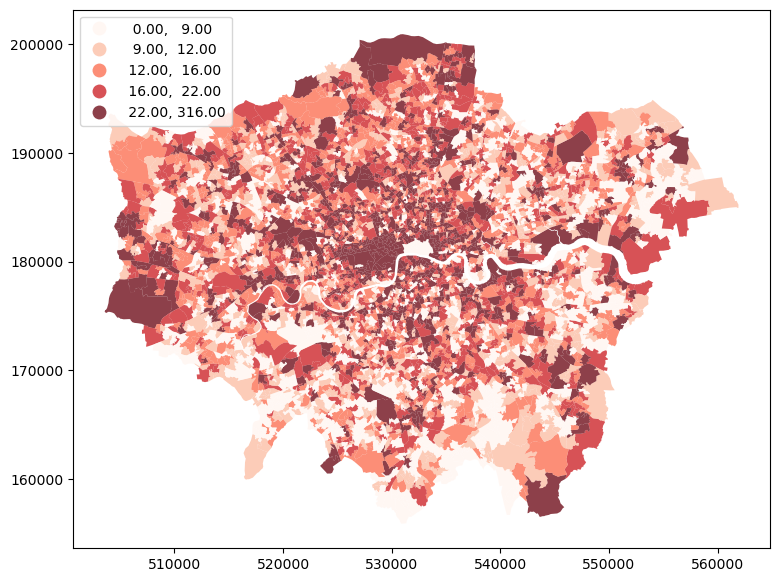

In [14]:
fig, ax = plt.subplots(1, figsize=(9, 9))
mps_lsoa_burglary_2019_gdf.plot(
    column="2019",
    cmap="Reds",
    scheme="Quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)

In [127]:
'''
### Global Spatial Autocorrelation
# Do you see any patterns? 
# Are burglaries randomly spread around the map? 
# Or would you say that areas that are closer to each other tend to be more alike? 
# Is there evidence of clustering? 
# Do burglaries seem to appear in certain pockets of the map?

--> Essentially aim to answer the degree to which areas that are near each other tend to be more alike.
--> quantifying whether areas are (on average) alike their neighbours.

'''

'\n### Global Spatial Autocorrelation\n# Do you see any patterns? \n# Are burglaries randomly spread around the map? \n# Or would you say that areas that are closer to each other tend to be more alike? \n# Is there evidence of clustering? \n# Do burglaries seem to appear in certain pockets of the map?\n\n--> Essentially aim to answer the degree to which areas that are near each other tend to be more alike.\n--> quantifying whether areas are (on average) alike their neighbours.\n\n'

In [129]:
w_rook_borough = Rook.from_dataframe(london_borough)

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is dep

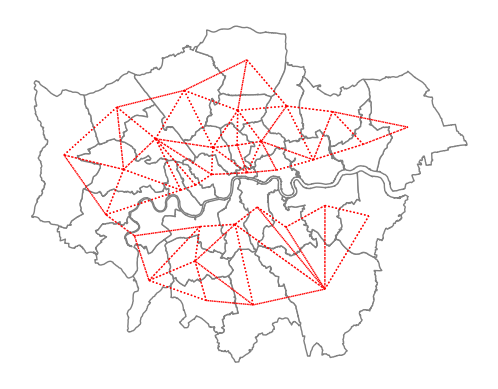

In [130]:
ax = london_borough.plot(edgecolor='grey', facecolor='w')
f,ax = w_rook_borough.plot(london_borough, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

In [148]:
## aggregating to ward level
mps_ward_burglary_2019_gdf = london_ward.sjoin(mps_lsoa_burglary_2019_gdf, how="left")

In [150]:
mps_ward_burglary_2019_gdf = mps_ward_burglary_2019_gdf.groupby("GSS_CODE").sum()

C:\Users\Mumu\AppData\Local\Temp\ipykernel_21772\1871524132.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [155]:
mps_ward_burglary_2019_gdf = mps_ward_burglary_2019_gdf.reset_index()

In [158]:
## adding the geometry column back
mps_ward_burglary_2019_gdf = london_ward.merge(mps_ward_burglary_2019_gdf, on="GSS_CODE", how="outer")

In [159]:
mps_ward_burglary_2019_gdf.columns

Index(['NAME', 'GSS_CODE', 'HECTARES_x', 'NONLD_AREA_x', 'LB_GSS_CD',
       'BOROUGH', 'POLY_ID_x', 'geometry', 'HECTARES_y', 'NONLD_AREA_y',
       'POLY_ID_y', 'index_right', 'USUALRES', 'HHOLDRES', 'COMESTRES',
       'POPDEN', 'HHOLDS', 'AVHHOLDSZ', '201903', '201904', '201905', '201906',
       '201907', '201908', '201909', '201910', '201911', '201912', '201901',
       '201902', '2019'],
      dtype='object')

In [160]:
len(mps_ward_burglary_2019_gdf)

649

In [161]:
len(london_ward)

649

<Axes: >

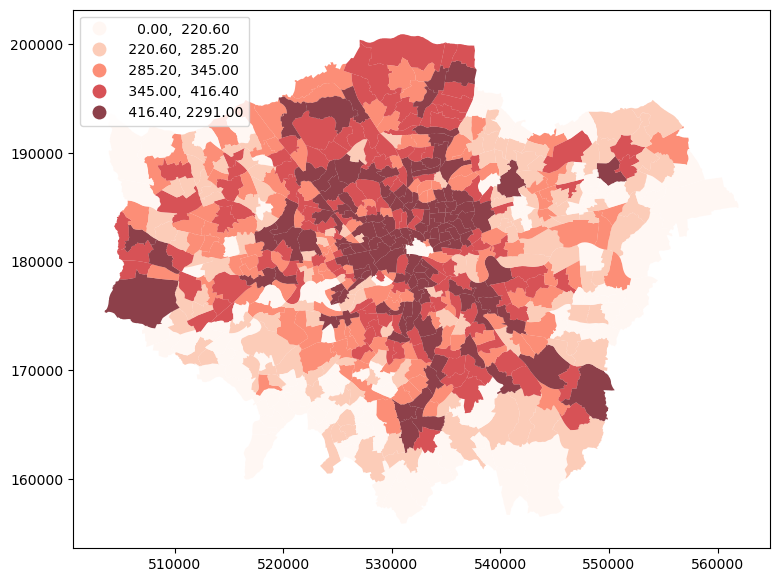

In [162]:
fig, ax = plt.subplots(1, figsize=(9, 9))
mps_ward_burglary_2019_gdf.plot(
    column="2019",
    cmap="Reds",
    scheme="Quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)

In [167]:
london_ward = london_ward.set_index("GSS_CODE")

In [181]:
# w_knn_8_ward = weights.KNN.from_dataframe(london_ward, k=8, ) #ids="GSS_CODE")
w_knn_8_ward = KNN.from_dataframe(london_ward, k=8, ) #ids="GSS_CODE")

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning:

Passing a dict as an indexer is dep

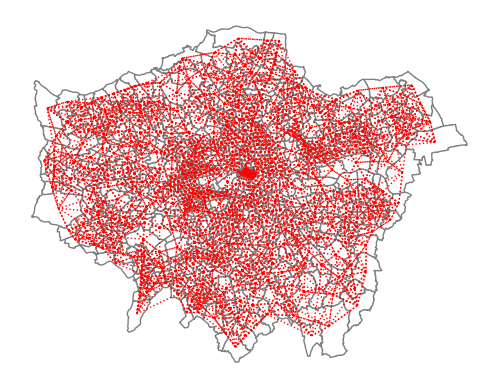

In [174]:
ax = london_ward.plot(edgecolor='grey', facecolor='w')
f,ax = w_knn_8_ward.plot(london_ward, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

In [188]:
# Row-standardization
w_knn_8_ward.transform = "R"

In [186]:
mps_ward_burglary_2019_gdf = mps_ward_burglary_2019_gdf.set_index("GSS_CODE")

In [189]:
w_knn_8_ward.weights

{'E05000405': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000414': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000401': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000400': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000402': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000406': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000404': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000413': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000410': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000412': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000408': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000403': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000409': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'E05000407': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 

In [191]:
mps_ward_burglary_2019_gdf["2019_lag"] = weights.spatial_lag.lag_spatial(
    w_knn_8_ward, mps_ward_burglary_2019_gdf["2019"]
)

In [192]:
mps_ward_burglary_2019_gdf

,NAME,HECTARES_x,NONLD_AREA_x,LB_GSS_CD,BOROUGH,POLY_ID_x,geometry,HECTARES_y,NONLD_AREA_y,POLY_ID_y,...,201907,201908,201909,201910,201911,201912,201901,201902,2019,2019_lag
GSS_CODE,,,,,,,,,,,,,,,,,,,,,
E05000405,Chessington South,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16...",7551.730,0.0,508400,...,8.0,4.0,4.0,6.0,10.0,6.0,9.0,7.0,73.0,134.500
E05000414,Tolworth and Hook Rise,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.600 165447.100, 517837.100 16...",3632.496,0.0,1640240,...,5.0,13.0,14.0,18.0,23.0,13.0,10.0,9.0,134.0,134.125
E05000401,Berrylands,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.500 167303.400, 518114.300 16...",2471.630,0.0,857633,...,11.0,16.0,4.0,7.0,14.0,13.0,8.0,12.0,130.0,182.875
E05000400,Alexandra,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480.000 166909.800, 520490.700 16...",4564.602,0.0,857752,...,11.0,6.0,10.0,14.0,10.0,18.0,12.0,18.0,140.0,148.500
E05000402,Beverley,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071.000 168144.900, 522063.900 16...",3380.778,0.0,2108898,...,9.0,5.0,10.0,21.0,22.0,18.0,30.0,22.0,194.0,208.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05000002,Aldgate,11.227,0.0,E09000001,City of London,51182,"POLYGON ((533326.100 181359.400, 533336.900 18...",22.454,0.0,102364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.500
E05000008,Broad Street,8.188,0.0,E09000001,City of London,50669,"POLYGON ((532703.800 181263.500, 532707.800 18...",8.188,0.0,50669,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.375
E05000012,Coleman Street,15.404,0.0,E09000001,City of London,122520,"POLYGON ((532880.500 181723.400, 532884.200 18...",46.212,0.0,367560,...,8.0,4.0,9.0,3.0,5.0,2.0,6.0,6.0,59.0,58.500


Text(0.5, 1.0, 'Burglary 2019 - Spatial Lag')

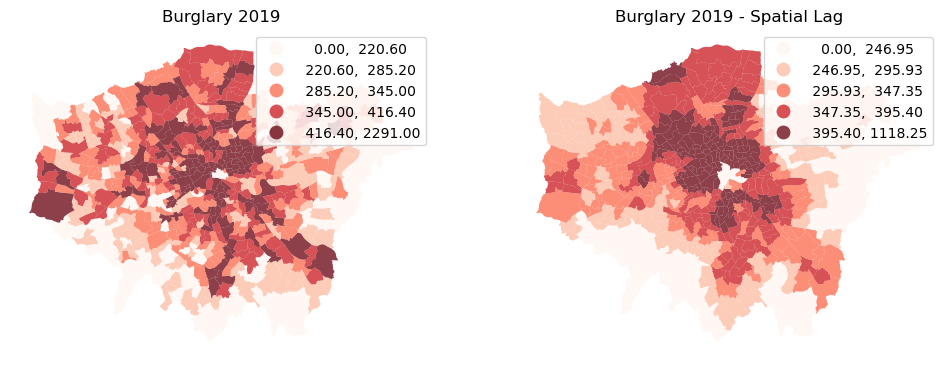

In [195]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

mps_ward_burglary_2019_gdf.plot(
    column="2019",
    cmap="Reds",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("Burglary 2019")

mps_ward_burglary_2019_gdf.plot(
    column="2019_lag",
    cmap="Reds",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("Burglary 2019 - Spatial Lag")

# plt.show()

In [198]:
## Binary case: joint counts
mps_ward_burglary_2019_gdf["2019_burglar_maj"] = (mps_ward_burglary_2019_gdf["2019"] > 313).astype(int)
mps_ward_burglary_2019_gdf[["2019", "2019_burglar_maj"]].tail()

,2019,2019_burglar_maj
GSS_CODE,,
E05000002,0.0,0
E05000008,0.0,0
E05000012,59.0,0
E05000021,118.0,0
E05000009,0.0,0


In [214]:
mps_ward_burglary_2019_gdf["2019"].median()

313.0

In [212]:
mps_ward_burglary_2019_gdf["2019"].describe()

count     649.000000
mean      332.599384
std       180.114221
min         0.000000
25%       238.000000
50%       313.000000
75%       396.000000
max      2291.000000
Name: 2019, dtype: float64

(500648.735, 564876.965, 153596.645, 203188.055)

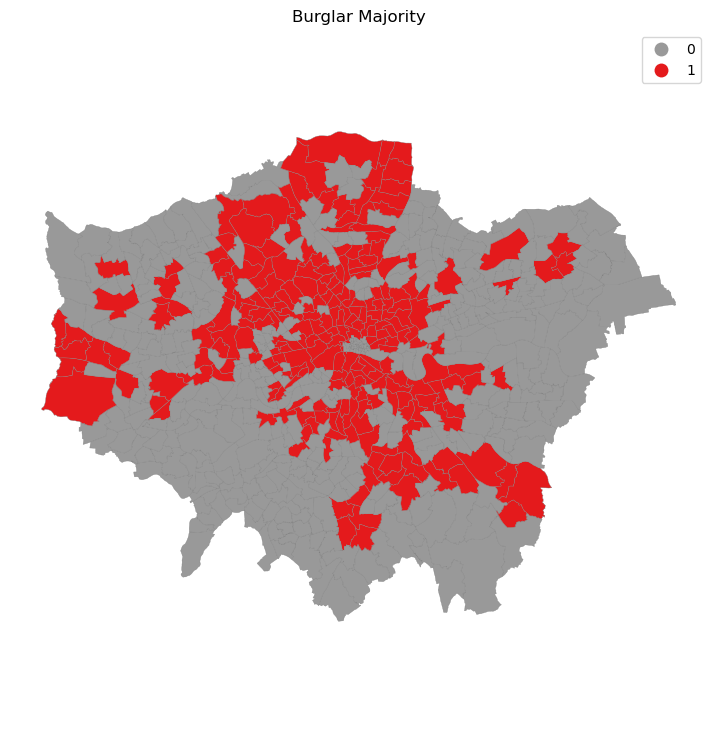

In [205]:
f, ax = plt.subplots(1, figsize=(9, 9))
mps_ward_burglary_2019_gdf.plot(
    ax=ax,
    column="2019_burglar_maj",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set1_r",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Burglar Majority")
plt.axis("equal")
# plt.show()

''' 
Visually, it appears that the map represents a clear case of positive spatial autocorrelation: 
overall, there are few visible cases where a given observation is surrounded by others in the opposite category. 
'''

In [206]:
w_knn_8_ward.transform

'R'

In [208]:
w_knn_8_ward.transform = "O"

In [210]:
w_knn_8_ward.transform

'O'

In [ ]:
seed(1234)
jc = esda.join_counts.Join_Counts(db["Leave"], w)
jc